## Description
In this notebook, we use a reference image (manually generated in GIMP) to generate a simulated mass spectrometric (MS) image with overlapping isotopic envelopes. We will manually define the molecular formulas of the ions and their proportions in each region of the image.     
We will simulate pixel-to-pixel variability in the MS image and measurement inaccuracies in individual spectra, including background noise.   

We will then perform regression of spectra using `masserstein`.      

Finally, we will compare four segmentation approaches: either based on peaks or `masserstein` estimates, and either using K-means or `spatial-DGMM` algorithms.  

Simulation steps:  
1. Generate reference spectra for different regions of the image using manually defined proportions
2. For each pixel: 
  1. Sample numbers of ions for each molecule, with an average value depending on the region of the image, and a constant coefficient of variance; 
  2. Distort each spectrum by sampling from the multinomial process with the number of molecules given by the corresponding distorted proportion; 
  3. Combine the distorted spectra; 
  4. Add a handful of noise peaks amounting for 5% of the total signal to simulate contaminants; 
  5. Apply a Gaussian filter to the spectra to lower the resolution; 
  6. Apply a Gaussian distortion to each intensity measurement to simulate electronic noise; 
  7. Centroid the spectrum.  

The result will be stored in imzML files for the profile and the centroided spectra.  

## Python modules

In [1]:
%matplotlib inline

In [2]:
import imageio
import numpy as np
import numpy.random as rd 
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
from pyimzml.ImzMLWriter import ImzMLWriter
from pyimzml.ImzMLParser import ImzMLParser
from copy import deepcopy
from scipy.stats import nbinom, pearsonr
from sklearn.cluster import KMeans
import pandas as pd

In [3]:
%load_ext rpy2.ipython

In [4]:
%R suppressPackageStartupMessages(library('Cardinal'))

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


## Loading and preparation of the reference image

Load the reference "optical" image: 

In [5]:
mask = imageio.imread('SimulationMask.png')

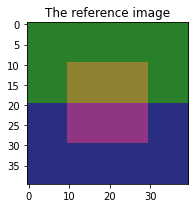

In [6]:
plt.figure(figsize=(3,3))
plt.title('The reference image')
plt.imshow(mask)
plt.tight_layout()
plt.show()

The image contains four regions corresponding to four different colors.   
Parse the image into four `numpy` arrays corresponding to each region:  

In [7]:
region1 = mask[:,:,1] == 128
region2 = mask[:,:,1] == 46
region3 = mask[:,:,1] == 130
region4 = mask[:,:,1] == 53

Generate a two-dimentional array storing the region index for each pixel:  

In [8]:
region_mapping = np.zeros(mask.shape[:2], dtype='int')
for reg_id, reg_value in enumerate([128, 46, 130, 53]):
    region_mapping[mask[:,:,1] == reg_value] = reg_id

Visualize individual regions:

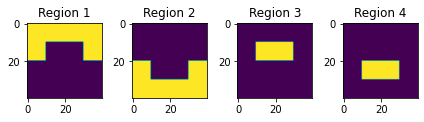

In [9]:
plt.figure(figsize=(6,2))
plt.subplot(141)
plt.title('Region 1')
plt.imshow(region1)
plt.subplot(142)
plt.title('Region 2')
plt.imshow(region2)
plt.subplot(143)
plt.title('Region 3')
plt.imshow(region3)
plt.subplot(144)
plt.title('Region 4')
plt.imshow(region4)
plt.tight_layout()
plt.show()

Show the combined regions:

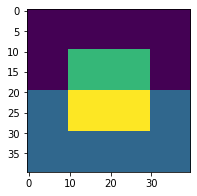

In [10]:
plt.figure(figsize=(3,3))
plt.imshow(region_mapping)
plt.show()

Compute the region areas:

In [11]:
region_areas = [np.sum(region_mapping==i) for i in range(4)]
print('Areas of regions in numbers of pixels:', region_areas)
assert sum(region_areas) == region_mapping.shape[0]*region_mapping.shape[1]

Areas of regions in numbers of pixels: [600, 600, 200, 200]


Generate masks of the top and bottom rectangles and the central square:

In [12]:
enrichment_mask = np.zeros(mask.shape[:2] + (3,), dtype='bool')
enrichment_mask[...,0] = region1 + region3
enrichment_mask[...,1] = region2 + region4
enrichment_mask[...,2] = region3 + region4

Optional: load the image from previous notebook run:

In [13]:
# profile_imzml = ImzMLParser('lipid_MSI_profile_mode.imzML')
# image = np.zeros((mask.shape[0], mask.shape[1], len(mass_axis)))
# for idx, (xcoord,ycoord,zcoord) in enumerate(profile_imzml.coordinates):
#     mz, intsy = profile_imzml.getspectrum(idx)
#     mz, intsy = np.array(mz), np.array(intsy)
#     image[ycoord,xcoord,...] = intsy

## Preparation of theoretical spectra

We will generate theoretical spectra of three lipids for use as references in the simulations

In [14]:
lipid_names = ['PC(38:1)', 'PA(44:0)', 'PC(38:0)']
lipid_formulas = ['C46H90NO8P', 'C47H93O8P', 'C46H92NO8P']

In [15]:
spectra = [Spectrum(f, adduct='K', threshold=0.001, label=n) for f, n in zip(lipid_formulas, lipid_names)]
for s in spectra:
    s.normalize()

Monoisotopic peaks of the lipids:

In [16]:
for s in spectra:
    print(s.label, s.confs[0][0], sep=': ')

PC(38:1): 854.6041123617
PA(44:0): 855.62451345431
PC(38:0): 856.61976242624


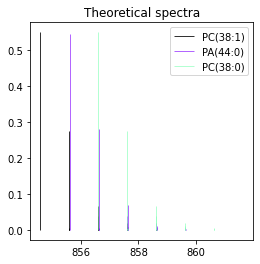

In [17]:
plt.figure(figsize=(4,4))
plt.title('Theoretical spectra')
Spectrum.plot_all(spectra)
plt.show()

## Image simulation

### Intensity averages

Generate a 4x3 array of average ion counts of the three lipids in the four regions.   
The array is constructed so that the isotopic peak of PC(38:1) overshadows the monoisotopic peak of PA(44:0).  

In [18]:
average_ion_counts = np.array([
    [1e04, 2e03, 1e03],
    [1e03, 4e03, 1e03],
    [1e04, 2e03, 2e03],
    [1e03, 4e03, 2e03]
], dtype='int')

Show the true distribution of lipid concentrations:

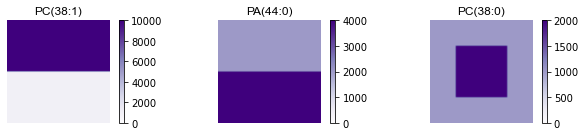

In [19]:
plt.figure(figsize=(9, 2))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(131 + lipid_id)
    spatial_intensity = average_ion_counts[region_mapping, lipid_id]
    plt.imshow(spatial_intensity, cmap=cm.Purples, vmin=0)
    plt.title(lipid_name, fontname='Arial')
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/simulations/lipid_enrichment_plot.png', dpi=300)

We'll now visualize the reference spectra (in profile mode) of the four image regions.  
First, define the mass axis for spectra in profile mode:

In [20]:
mass_axis = np.arange(854, 860, 0.01)

Define the peak width (in terms of standard deviation of a Gaussian): 

In [21]:
peak_sd = 0.05

Generate theoretical profile spectra:  

In [22]:
profile_spectra = [deepcopy(s) for s in spectra]
for i, ps in enumerate(profile_spectra):
    ps.gaussian_smoothing(peak_sd, 0.01)
    profile_spectra[i] = ps.resample(mass_axis)

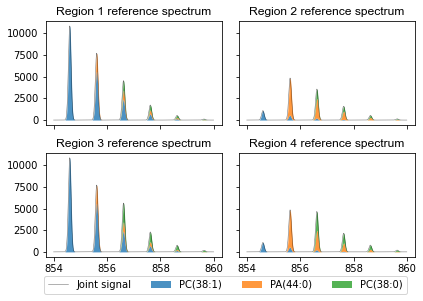

In [23]:
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

for i in range(average_ion_counts.shape[0]):
    plt.subplot(221 + i)
    plt.title('Region %i reference spectrum' % (i+1), fontname='Arial')
    cumulative_intensity = np.zeros(mass_axis.shape)
    for j in range(average_ion_counts.shape[1]):
        ions = average_ion_counts[i, j]/4
        current_intensity = np.array([i*ions for m, i in profile_spectra[j].confs])
        plt.fill_between(mass_axis, 
                         cumulative_intensity, 
                         current_intensity+cumulative_intensity,
                         facecolor=cmap(j, alpha=0.8), edgecolor=(0,0,0,0))
        cumulative_intensity += current_intensity
    plt.plot(mass_axis, cumulative_intensity, color='k', alpha=0.6, lw=0.5)
lgd = fig.legend(['Joint signal'] + lipid_names, loc='lower center', bbox_to_anchor=(.53, -.05), ncol=4)
plt.tight_layout()
plt.savefig('Figs/simulations/region_rainbow_reference.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=600)

Note that the monoisotopic peak of PA(44:0) at 855.6 is higher in region 1 than in region 2 due to the contribution of PC(38:1) to its intensity.  

### Intensity variances 

Calculate standard deviations of ion molecules for a fixed coefficient of variance, for a peak with intensity 0.5:

In [24]:
coefficient_of_variance = 0.4
ion_count_variance = average_ion_counts**2*coefficient_of_variance**2 - average_ion_counts
np.sqrt(ion_count_variance)

array([[3998.74980463,  798.74902191,  398.74804075],
       [ 398.74804075, 1598.74951134,  398.74804075],
       [3998.74980463,  798.74902191,  798.74902191],
       [ 398.74804075, 1598.74951134,  798.74902191]])

### Whole image simulation

We'll simulate each pixel independently.   
In each pixel, we'll draw the number of ions of each lipid from the negative binomial distribution, with the average and variance given by `average_ion_counts` and `ion_count_variance`.  
Next, we'll combine the theoretical spectra of the three lipids in proportions given by the drawn numbers of ions.  
Next, we'll add a given number of randomly located peaks to simulate additional confounding signals. The number of added peaks is controlled by the `nb_of_noise_peaks` variable, and the total proportion of signal in the spectrum that they will correspond to is controlled by the `noise_proportion` variable.   
Next, we'll apply a Gaussian filter with standard deviation given by the `peak_sd` variable defined earlier, to get spectra in profile mode.   
Finally, we'll resample the spectrum so that the m/z measurements correspond to `mass_axis` defined earlier.   

In [25]:
nb_of_noise_peaks = 10
noise_proportion = 0.1

In [26]:
image = np.zeros((mask.shape[0], mask.shape[1], len(mass_axis)))
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        region_id = region_mapping[i, j]
        ion_counts = average_ion_counts[region_id]
        count_vars = ion_count_variance[region_id]
        nbinom_p = ion_counts/count_vars
        nbinom_n = ion_counts**2/(count_vars-ion_counts)
        pixel_spectrum = Spectrum()
        for s, p, n in zip(spectra, nbinom_p, nbinom_n):
            nb_of_ions = nbinom.rvs(p=p, n=n)
            s = Spectrum.sample_multinomial(s, nb_of_ions, 1, 0.001)
            pixel_spectrum += s
        pixel_spectrum.add_chemical_noise(nb_of_noise_peaks, noise_proportion)
        pixel_spectrum.gaussian_smoothing(peak_sd, 0.01)
        pixel_spectrum = pixel_spectrum.resample(mass_axis)
        pixel_spectrum.set_confs([c for c in pixel_spectrum.confs if c[1] >= 0])
        image[i,j,:] = [y for x,y in pixel_spectrum.confs]

### Calculating the monoisotopic peak areas in the simulated image

Manually defined regions for integration of the monoisotopic peaks:  
(we could as well centroid the pixel spectra and then select the monoisotopic peaks, but this is a faster way that gives the same results) 

In [27]:
integration_regions = [
    (854.4, 854.8),
    (855.4, 855.8),
    (856.4, 856.8)
]

In [28]:
integrated_peak_areas = np.zeros(mask.shape[:2] + (len(integration_regions), ))
for peak_id, peak_region in enumerate(integration_regions):
    areas = np.zeros(mask.shape[:2])
    for i in range(areas.shape[0]):
        for j in range(areas.shape[1]):
            intsy = image[i, j]
            to_take = (mass_axis >= peak_region[0])*(mass_axis <= peak_region[1])
            areas[i,j] = np.trapz(intsy[to_take], mass_axis[to_take])
    integrated_peak_areas[:,:,peak_id] = areas

## Verification of the simulation results

Example simulated spectra:

In [29]:
selected_coords = [next(zip(*np.where(region_mapping==i))) for i in range(4)]

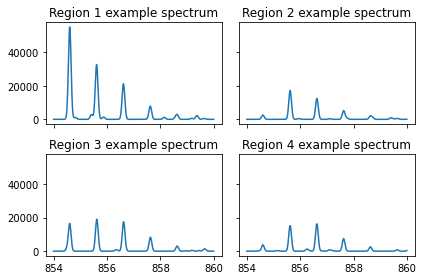

In [30]:
plt.subplots(2, 2, sharex=True, sharey=True)
for i, crd in enumerate(selected_coords):
    plt.subplot(221+i)
    plt.title('Region %i example spectrum' % (i+1))
    plt.plot(mass_axis, image[crd])
plt.tight_layout()
plt.savefig('Figs/simulations/region_example.png', dpi = 300)

Generate peak intensity images:

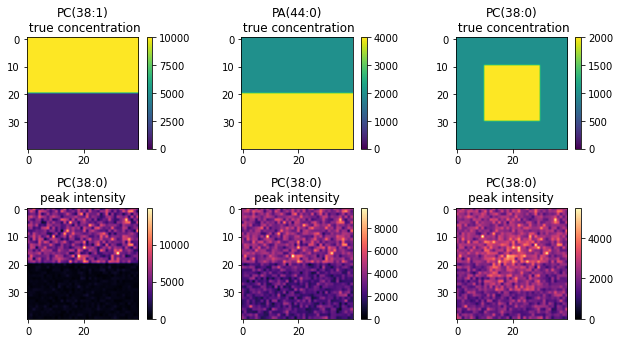

In [31]:
plt.subplots(2, 3, figsize=(9, 7))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(331 + lipid_id)
    spatial_intensity = average_ion_counts[region_mapping, lipid_id]
    plt.imshow(spatial_intensity, vmin=-1) # , vmin=-1, vmax=10000)
    plt.title(lipid_name + '\n true concentration')
    plt.colorbar()
for peak_id, peak_region in enumerate(integration_regions):
    plt.subplot(334 + peak_id)
    plt.title(lipid_name + '\npeak intensity')
    plt.imshow(integrated_peak_areas[..., peak_id], cmap=cm.magma, vmin=-1)# , vmin=-1, vmax=8000)
    plt.colorbar()
plt.tight_layout()

We can already appreciate the effect of peak overlaps and pixel-to-pixel variability.  

Visualize the distribution of peak areas for each lipid:

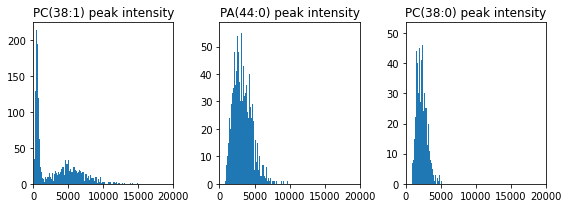

In [32]:
plt.subplots(1, 3, figsize=(8,3))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(131 + lipid_id)
    plt.xlim(0, 20000)
    plt.title(lipid_name + ' peak intensity')
    plt.hist(integrated_peak_areas[:,:,lipid_id].reshape((-1,)), bins=100)
plt.tight_layout()

## Regressing the theoretical spectra against the simulated pixel spectra

We'll quantify the amount of signal of each lipid in each pixel spectrum.   
Not that we'll quantify the total signal of each lipid (i.e. it's going to be proportional to the total ion current in the analyzed spectrum) rather than the proportion of the signal (i.e. a relative concentration of each lipid).   

In [33]:
estimated_lipid_signals = np.zeros(mask.shape[:2] + (len(spectra), ))
# # If we want to quantify signals directly from the profile-mode spectra (without centroiding):
# profile_estimated_lipid_signals = np.zeros(mask.shape[:2] + (len(spectra), ))
for xid in range(mask.shape[0]):
    for yid in range(mask.shape[1]):
        intensity = image[xid, yid]
        TIC = np.trapz(intensity, mass_axis)
        s = Spectrum(confs=list(zip(mass_axis, intensity)))
        # # If we want to quantify signals directly from the profile-mode spectra (without centroiding):
        # s.normalize()
        # regression = estimate_proportions(s, spectra, progress=False, MTD=0.2)
        # proportions = np.array(regression['proportions'])
        # signals = proportions*TIC
        # profile_estimated_lipid_signals[xid, yid] = signals
        
        # Centroid the spectrum & regress against the theoretical spectra: 
        s = Spectrum(confs=s.centroid(max_width=0.4, peak_height_fraction=0.2)[0])
        s.normalize()
        regression = estimate_proportions(s, spectra, progress=False, MTD=0.2)
        proportions = np.array(regression['proportions'])
        # Multiply the estimated proportions of lipids by the total ion current
        # to obtain the estimated signal contributions:  
        signals = proportions*TIC
        estimated_lipid_signals[xid, yid] = signals

Compare the estimated signal with the monoisotopic peak area and the true distribution of the lipids:   

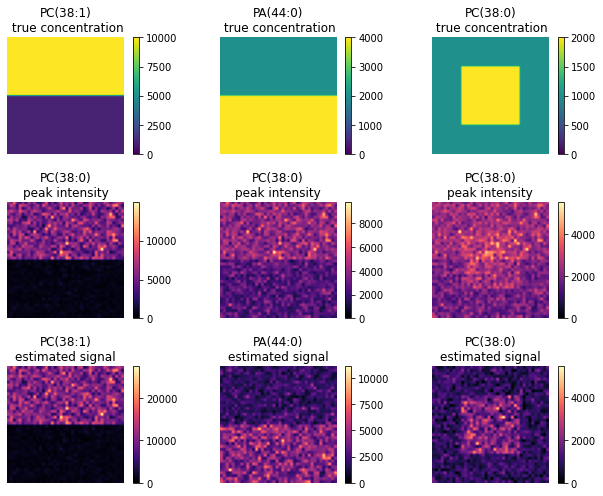

In [34]:
plt.subplots(3, 3, figsize=(9, 7))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(3, 3, 1 + lipid_id)
    spatial_intensity = average_ion_counts[region_mapping, lipid_id]
    plt.imshow(spatial_intensity, vmin=-1) 
    plt.axis('off')
    plt.title(lipid_name + '\n true concentration')
    plt.colorbar()
for peak_id, peak_region in enumerate(integration_regions):
    plt.subplot(3, 3, 4 + peak_id)
    plt.title(lipid_name + '\npeak intensity')
    plt.imshow(integrated_peak_areas[..., peak_id], cmap=cm.magma, vmin=-1)
    plt.axis('off')
    plt.colorbar()
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(3, 3, 7 + lipid_id)
    plt.imshow(estimated_lipid_signals[...,lipid_id], cmap=cm.magma, vmin=-1)
    plt.title(lipid_name + '\nestimated signal')
    plt.axis('off')
    plt.colorbar()    
    
plt.tight_layout()
plt.savefig('Figs/simulations/peak_vs_signal.png', dpi=600)

## K-means image segmentation

A simple K-means image segmentation based on peak areas:

In [35]:
peak_kmeans_segmentation = np.zeros(integrated_peak_areas.shape)
nclust = 2
for lipid_id, lipid_name in enumerate(lipid_names):
    peak_intensities = integrated_peak_areas[:,:,lipid_id]
    peak_intensities = peak_intensities.reshape((-1,1))
    peak_kmeans = KMeans(n_clusters=nclust)
    region_classification = peak_kmeans.fit_predict(peak_intensities)
    region_classification = region_classification.reshape(40, 40)
    region_classification = np.argsort(np.argsort(peak_kmeans.cluster_centers_.reshape((-1,))))[region_classification]
    peak_kmeans_segmentation[..., lipid_id] = region_classification
    

K-means image segmentation based on estimated signals:

In [36]:
masserstein_kmeans_segmentation = np.zeros(integrated_peak_areas.shape)
for lipid_id, lipid_name in enumerate(lipid_names):
    lipid_signals = estimated_lipid_signals[:,:,lipid_id]
    lipid_signals = lipid_signals.reshape((-1,1))
    peak_kmeans = KMeans(n_clusters=nclust)
    region_classification = peak_kmeans.fit_predict(lipid_signals)
    region_classification = region_classification.reshape(40, 40)
    lipid_signals = lipid_signals.reshape((40, 40))
    region_classification = np.argsort(np.argsort(peak_kmeans.cluster_centers_.reshape((-1,))))[region_classification]
    masserstein_kmeans_segmentation[..., lipid_id] = region_classification
    

## spatial-DGMM image segmentation

Now, we'll perform a spatial-DGMM segmentations based on peak intensities and based on masserstein estimates.   
First, convert the signal and intensity arrays to data frames in a long format 

In [37]:
coords = [[j, i] for i in range(40) for j in range(40)]

In [38]:
integrated_peak_areas_melt = [integrated_peak_areas[i,j,...] for i in range(40) for j in range(40)] 
estimated_lipid_signals_melt = [estimated_lipid_signals[i,j,...] for i in range(40) for j in range(40)] 

In [39]:
integrated_peak_areas_df = pd.DataFrame(integrated_peak_areas_melt, columns = lipid_names)
estimated_lipid_signals_df = pd.DataFrame(estimated_lipid_signals_melt, columns = lipid_names)

Import the prepared data frames into the R environment

In [40]:
%R -i integrated_peak_areas_df 
%R -i estimated_lipid_signals_df
%R -i coords
%R -i lipid_names

Prepare the `MSImagingExperiment` objects from the `Cardinal` package

In [41]:
%%R 

intsy_data <- t(integrated_peak_areas_df)
signal_data <- t(estimated_lipid_signals_df)
fdata <- MassDataFrame(mz=1:3, row.names=as.character(lipid_names))
run <- factor(rep("run0", ncol(coords)))
pdata <- PositionDataFrame(run=run, coord=t(coords))

masserstein_image <- MSImagingExperiment(imageData=signal_data,
                                         featureData=fdata,
                                         pixelData=pdata)

intensity_image <- MSImagingExperiment(imageData=intsy_data,
                                       featureData=fdata,
                                       pixelData=pdata)

Visualize the obtained images to verify if the imports and convertions were successful.  

In [42]:
#%%R 
#image(intensity_image,feature=2)

In [43]:
#%%R 
#image(masserstein_image,feature=2)

Do the segmentation:

In [156]:
%%R 

peak_sdgmm <- spatialDGMM(intensity_image, r=4, k=2, method="adaptive", dist='chebyshev',
                          init = 'gmm', tol=1e-12, iter.max=2000)
masserstein_sdgmm <- spatialDGMM(masserstein_image, r=4, k=2, method="adaptive", dist='chebyshev',
                                 init = 'gmm', tol=1e-12, iter.max=2000)

calculating spatial weights...
segmenting feature images...
r = 4, k = 2, feature = 1 . 
r = 4, k = 2, feature = 2 . 
r = 4, k = 2, feature = 3 . 
calculating spatial weights...
segmenting feature images...
r = 4, k = 2, feature = 1 . 
r = 4, k = 2, feature = 2 . 
r = 4, k = 2, feature = 3 . 


Visualize segmentations in R prior to importing back to Python:

R[write to console]: In addition: 
R[write to console]: There were 18 warnings (use warnings() to see them)
R[write to console]: 



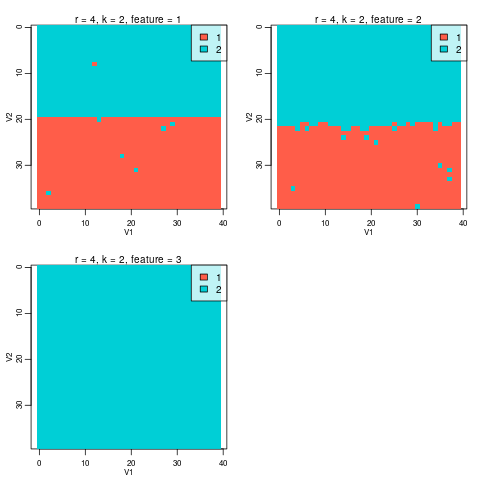

In [157]:
%%R 

image(peak_sdgmm, values='class')

R[write to console]: In addition: 
R[write to console]: There were 18 warnings (use warnings() to see them)
R[write to console]: 



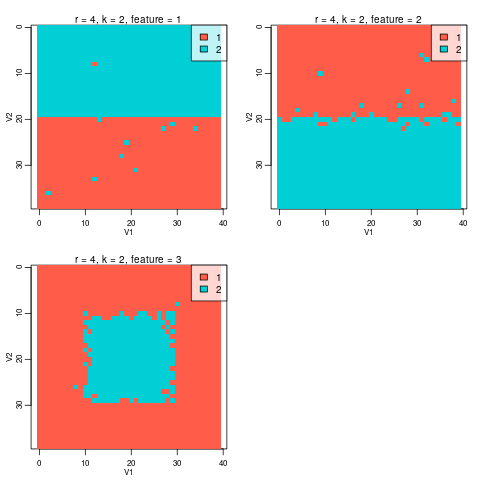

In [153]:
%%R

image(masserstein_sdgmm, values='class')

In [126]:
%%R

masserstein_sdgmm_segmentation_melt <- sapply(1:3, function(i) as.numeric(resultData(masserstein_sdgmm)[[i]]$class))
peak_sdgmm_segmentation_melt <- sapply(1:3, function(i) as.numeric(resultData(peak_sdgmm)[[i]]$class))


In [127]:
masserstein_sdgmm_segmentation_melt = %Rget masserstein_sdgmm_segmentation_melt
peak_sdgmm_segmentation_melt = %Rget peak_sdgmm_segmentation_melt

In [128]:
masserstein_sdgmm_segmentation = np.array(
    [
        [
            [
                masserstein_sdgmm_segmentation_melt[40*i+j,k] for k in range(3) 
            ]  for j in range(40)
        ] for i in range(40)
    ]
)
masserstein_sdgmm_segmentation -= 1

peak_sdgmm_segmentation = np.array(
    [
        [
            [
                peak_sdgmm_segmentation_melt[40*i+j,k] for k in range(3) 
            ]  for j in range(40)
        ] for i in range(40)
    ]
)
peak_sdgmm_segmentation -= 1

Verify a successful conversion:

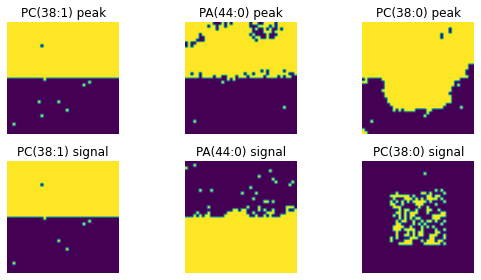

In [129]:
plt.subplots(2,3, figsize=(8,4))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(231+lipid_id)
    plt.title(lipid_name + ' peak')
    plt.imshow(peak_sdgmm_segmentation[..., lipid_id])
    plt.axis('off')
    plt.subplot(234+lipid_id)
    plt.title(lipid_name + ' signal')
    plt.imshow(masserstein_sdgmm_segmentation[..., lipid_id])
    plt.axis('off')
plt.tight_layout()

## Comparison of segmentation results

Visualize segments obtained with the four approaches:

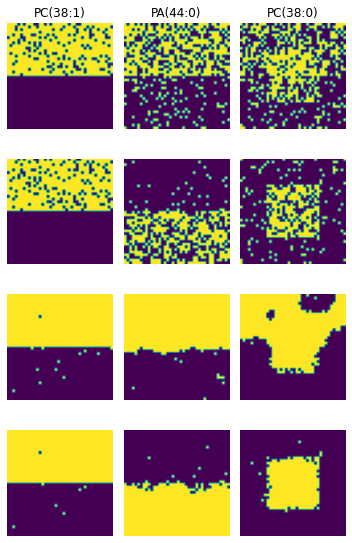

In [51]:
plt.subplots(4, 3, figsize=(5,8))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(4, 3, 1 + lipid_id)
    plt.title(lipid_name)
    plt.imshow(peak_kmeans_segmentation[..., lipid_id])
    plt.axis('off')
    
    plt.subplot(4, 3, 4 + lipid_id)
    plt.imshow(masserstein_kmeans_segmentation[..., lipid_id])
    plt.axis('off')
    
    plt.subplot(4, 3, 7 + lipid_id)
    plt.imshow(peak_sdgmm_segmentation[..., lipid_id])
    plt.axis('off')
    
    plt.subplot(4, 3, 10 + lipid_id)
    plt.imshow(masserstein_sdgmm_segmentation[..., lipid_id])
    plt.axis('off')
    
plt.tight_layout()
plt.savefig('Figs/simulations/segmentation_comparison.png', dpi=600)

Visualize the distribution of signals in clusters

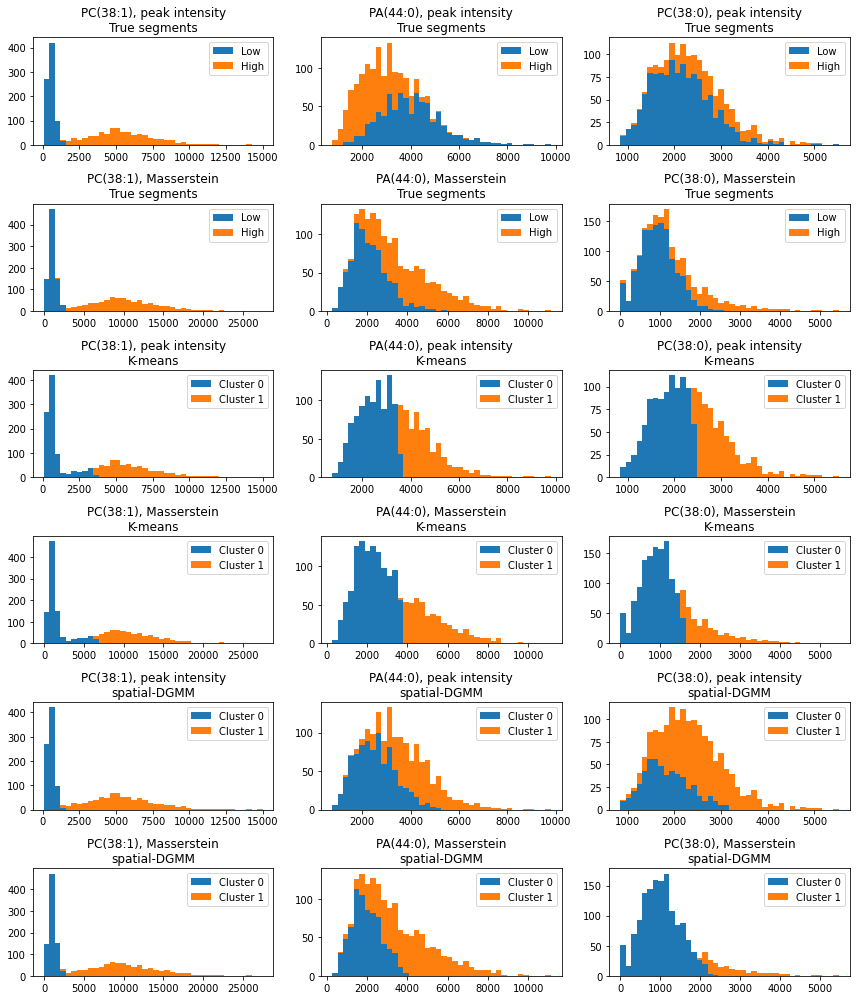

In [158]:
plt.subplots(6, 3, figsize=(12,14))
for lipid_id, lipid_name in enumerate(lipid_names):
    plt.subplot(6, 3, 1 + lipid_id)
    plt.hist([integrated_peak_areas[enrichment_mask[..., lipid_id]==i, lipid_id] for i in range(nclust)], stacked=True, bins=40)
    plt.legend(['Low','High'])
    plt.title(lipid_name + ', peak intensity\nTrue segments')
    
    plt.subplot(6, 3, 4 + lipid_id)
    plt.hist([estimated_lipid_signals[enrichment_mask[..., lipid_id]==i, lipid_id] for i in range(nclust)], stacked=True, bins=40)
    plt.legend(['Low','High'])
    plt.title(lipid_name + ', Masserstein\nTrue segments')
    
    plt.subplot(6, 3, 7 + lipid_id)
    plt.hist([integrated_peak_areas[peak_kmeans_segmentation[..., lipid_id]==i, lipid_id] for i in range(nclust)], stacked=True, bins=40)
    plt.legend(['Cluster 0','Cluster 1'])
    plt.title(lipid_name + ', peak intensity\nK-means')
    
    plt.subplot(6, 3, 10 + lipid_id)
    plt.hist([estimated_lipid_signals[masserstein_kmeans_segmentation[..., lipid_id]==i, lipid_id] for i in range(nclust)], stacked=True, bins=40)
    plt.legend(['Cluster 0','Cluster 1'])
    plt.title(lipid_name + ', Masserstein\nK-means')
    
    plt.subplot(6, 3, 13 + lipid_id)
    plt.hist([integrated_peak_areas[peak_sdgmm_segmentation[..., lipid_id]==i, lipid_id] for i in range(nclust)], stacked=True, bins=40)
    plt.legend(['Cluster 0','Cluster 1'])
    plt.title(lipid_name + ', peak intensity\nspatial-DGMM')
    
    plt.subplot(6, 3, 16 + lipid_id)
    plt.hist([estimated_lipid_signals[masserstein_sdgmm_segmentation[..., lipid_id]==i, lipid_id] for i in range(nclust)], stacked=True, bins=40)
    plt.legend(['Cluster 0','Cluster 1'])
    plt.title(lipid_name + ', Masserstein\nspatial-DGMM')
plt.tight_layout()
plt.savefig('Figs/simulations/intensity_distributions_in_clusters.png', dpi=600)

Accuracy of different segmentation approaches

In [82]:
nclust = 2

algorithms = ['Peak K-means', 'WS K-means', 'Peak sDGMM', 'WS sDGMM']
accuracy = np.zeros((len(lipid_names), len(algorithms)))
correlation = np.zeros((len(lipid_names), len(algorithms)))

for lipid_id, lipid_name in enumerate(lipid_names):
    # Peak K-means
    region_classification = peak_kmeans_segmentation[..., lipid_id]
    accuracy[lipid_id, 0] = np.mean(region_classification == enrichment_mask[...,lipid_id])
    correlation[lipid_id, 0] = pearsonr(region_classification.flatten(), enrichment_mask[...,lipid_id].flatten())[0]
    # WS K-means
    region_classification = masserstein_kmeans_segmentation[..., lipid_id]
    accuracy[lipid_id, 1] = np.mean(region_classification == enrichment_mask[...,lipid_id])
    correlation[lipid_id, 1] = pearsonr(region_classification.flatten(), enrichment_mask[...,lipid_id].flatten())[0]
    # Peak spatialDGMM
    region_classification = peak_sdgmm_segmentation[..., lipid_id]
    accuracy[lipid_id, 2] = np.mean(region_classification == enrichment_mask[...,lipid_id])
    correlation[lipid_id, 2] = pearsonr(region_classification.flatten(), enrichment_mask[...,lipid_id].flatten())[0]
    # WS spatialDGMM
    region_classification = masserstein_sdgmm_segmentation[..., lipid_id]
    # ws_sdgmm_specificity[lipid_id] = np.sum(region_classification * enrichment_mask[...,lipid_id])/np.sum(enrichment_mask[...,lipid_id])
    accuracy[lipid_id, 3] = np.mean(region_classification == enrichment_mask[...,lipid_id])
    correlation[lipid_id, 3] = pearsonr(region_classification.flatten(), enrichment_mask[...,lipid_id].flatten())[0]

average_accuracy = np.mean(accuracy, axis=0)
average_correlation = np.mean(correlation, axis=0)

In [93]:
print('Accuracy of segmentation:')
print('Lipid     ', 'Peak K-means', 'WS K-means', 'Peak sDGMM', 'WS sDGMM', sep='\t')
for i, n in enumerate(lipid_names):
    acc_vec = ['{:2.2f}%     '.format(100*x) for x in accuracy[i]]
    print(n, *acc_vec, sep='\t')
print('Average     ', *['{:2.2f}%     '.format(100*x) for x in average_accuracy], sep='\t')
print('Correlation of segmentation:')
print('Lipid     ', 'Peak K-means', 'WS K-means', 'Peak sDGMM', 'WS sDGMM', sep='\t')
for i, n in enumerate(lipid_names):
    corr_vec = ['{:0.4f}     '.format(x) for x in correlation[i]]
    print(n, *corr_vec, sep='\t')
print('Average     ', *['{:0.4f}     '.format(x) for x in average_correlation], sep='\t')

Accuracy of segmentation:
Lipid     	Peak K-means	WS K-means	Peak sDGMM	WS sDGMM
PC(38:1)	92.00%     	91.81%     	99.88%     	99.94%     
PA(44:0)	27.06%     	75.19%     	0.88%     	98.00%     
PC(38:0)	69.25%     	84.38%     	61.31%     	94.19%     
Average     	62.77%     	83.79%     	54.02%     	97.38%     
Correlation of segmentation:
Lipid     	Peak K-means	WS K-means	Peak sDGMM	WS sDGMM
PC(38:1)	0.8510     	0.8477     	0.9975     	0.9988     
PA(44:0)	-0.4867     	0.5425     	-0.9825     	0.9608     
PC(38:0)	0.2691     	0.5579     	0.3047     	0.8435     
Average     	0.2111     	0.6494     	0.1066     	0.9343     


## Saving the results

Save the table of lipid formulas used in the simulation and their monoisotopic peaks:

In [14]:
# with open('lipid_table.tsv', 'w') as h:
#     h.write('\t'.join(['Name', 'Formula', 'Monoisotopic mass']) + '\n')
#     for s in spectra:
#         h.write(s.label + '\t' + s.formula + '\t' + str(s.confs[0][0]) + '\n')

Save the image in profile mode in imzML:

In [ ]:
# with ImzMLWriter('lipid_MSI_profile_mode.imzML') as writer:
#     for i in range(mask.shape[0]):
#         if not i % 50:
#             print(i)
#         for j in range(mask.shape[1]):
#             writer.addSpectrum(mass_axis, image[i,j,:], (j, i))

Centroid the image and save it in imzML:

In [ ]:
# with ImzMLWriter('lipid_MSI_centroid_mode.imzML') as writer:
#     for i in range(mask.shape[0]):
#         if not i % 50:
#             print(i)
#         for j in range(mask.shape[1]):
#             S = Spectrum(confs=list(zip(mass_axis, image[i,j,:])))
#             peaks, _ = S.centroid(max_width = 0.4, peak_height_fraction=0.2)
#             mzs = [p[0] for p in peaks]
#             intsys = [p[1] for p in peaks]
#             writer.addSpectrum(mzs, intsys, (j, i))

Save the results of regression of spectra:

In [106]:
# with open('lipid_regression_results.tsv', 'w') as h:
#     h.write('\t'.join(['X', 'Y']+names) + '\n')
#     for x_coord in range(estimated_lipid_signals.shape[1]):
#         for y_coord in range(estimated_lipid_signals.shape[0]):
#             h.write('\t'.join(map(str, (x_coord, y_coord))))
#             h.write('\t')
#             h.write('\t'.join(map(str, estimated_lipid_signals[y_coord, x_coord, ...])))
#             h.write('\n')